# Setup

In [1]:
import itertools as it
import pickle

import graph_tool.all as gt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set(style='white', palette='Accent')

# Functions

In [2]:
### File Functions
graphs_pkl = None
def load_graph_by_id(graph_id, source='attention', column=None, **kwargs):
    # From individual graphs
    if source == 'coexpression':
        column = 'CoexWeight' if column is None else column
        # Get graph
        graph = pd.read_csv(f'./data/PsychAD_freeze2_personalized_grpahs/regulon_grn/{graph_id}_regulon_list.csv')[['TF', 'gene', column, 'regulon']]
        graph = graph.rename(columns={'gene': 'TG', column: 'coef'})  # TF, TG, coef, regulon

    # From pkl
    elif source == 'attention':
        column = 'att_mean' if column is None else column
        # Load pkl if not already loaded
        global graphs_pkl
        if not graphs_pkl:
            with open(f'./data/ting/homo_5_TF_1_target_graph_with_att.pkl', 'rb') as f:
                graphs_pkl = pickle.load(f)
        # Get graph
        graph = graphs_pkl[graph_id][['from_gene', 'to_gene', column]]
        graph = graph.rename(columns={'from_gene': 'TF', 'to_gene': 'TG', column: 'coef'})  # TF, TG, coef
    
    # Exception
    else:
        raise Exception(f'Source \'{source}\' not found.')
    
    return graph

In [3]:
### Computational Functions
def compute_statistics(meta, x, x_sub, **kwargs):
    # Initialize graph summary list
    graph_summary_list = []

    # Get unique values
    unique_x = meta[x].unique()
    unique_x_sub = meta[x_sub].unique()

    # Calculate per graph
    for val, val_sub in tqdm(it.product(unique_x, unique_x_sub), total=len(unique_x)*len(unique_x_sub)):
        graph_ids = list(meta[(meta[x]==val)*(meta[x_sub]==val_sub)]['SubID'])
        
        num_samples = len(graph_ids)  # 10
        for graph_id in np.random.choice(graph_ids, min(len(graph_ids), num_samples), replace=False):
            # Load graph
            try:
                graph = load_graph_by_id(graph_id, **kwargs)
            except:
                continue

            # Filter synthetic cells
            if 'source' in kwargs and kwargs['source'] == 'attention':
                synthetic_vertices = list(graph[graph['TG'] == 'hub']['TF'])
            else:
                synthetic_vertices = []

            # TODO: Filter by coef, cell-type regulons
            
            # Results
            results_list = [graph_id, val, val_sub]

            ### Using all edges
            # Calculate TF outgoing
            tf_outgoing = np.mean([(graph['TF']==gene).sum() for gene in graph['TF'].unique() if gene not in synthetic_vertices])
            results_list.append(tf_outgoing)

            # Calculate TG outgoing (Long Runtime)
            tg_outgoing = 0  # np.mean([(graph['TG']==gene).sum() for gene in graph['TG'].unique() if gene not in synthetic_vertices])
            results_list.append(tg_outgoing)

            # Calculate TF closeness
            graph_nx = nx.from_pandas_edgelist(graph, 'TF', 'TG', 'coef')
            tf_closeness = np.mean([nx.closeness_centrality(graph_nx, u=gene) for gene in graph['TF'].unique() if gene not in synthetic_vertices])
            results_list.append(tf_closeness)

            ### Using high (>80%) coef
            # Filter to high coef
            graph_att_shortened = graph[graph['coef'] > graph['coef'].quantile(.8)]

            # Calculate TF outgoing
            tf_outgoing = np.mean([(graph_att_shortened['TF']==gene).sum() for gene in graph_att_shortened['TF'].unique() if gene not in synthetic_vertices])
            results_list.append(tf_outgoing)

            # Calculate TG outgoing (Long Runtime)
            tg_outgoing = 0  # np.mean([(graph_att_shortened['TG']==gene).sum() for gene in graph_att_shortened['TG'].unique() if gene not in synthetic_vertices])
            results_list.append(tg_outgoing)

            # Calculate TF closeness
            graph_nx = nx.from_pandas_edgelist(graph_att_shortened, 'TF', 'TG', 'coef')
            tf_closeness = np.mean([nx.closeness_centrality(graph_nx, u=gene) for gene in graph_att_shortened['TF'].unique() if gene not in synthetic_vertices])
            results_list.append(tf_closeness)

            # Record results
            graph_summary_list.append(results_list)

    # Create summary df
    graph_summary = pd.DataFrame(graph_summary_list, columns=[
        'Graph ID',
        'Phenotype',
        'Sub-Phenotype',
        'TF Outgoing',
        'TG Outgoing',
        'TF Closeness',
        'Attention-Filtered TF Outgoing',
        'Attention-Filtered TG Outgoing',
        'Attention-Filtered TF Closeness',
    ])

    # Return
    return graph_summary


def compute_graph(graph):
    # Detect synthetic vertices
    synthetic_vertices = list(graph[graph['TG'] == 'hub']['TF'])
    cell_vertices = [v for v in synthetic_vertices if v != 'hub']

    # Convert graph to graph_tools
    list_of_tuples = list(graph.itertuples(index=False, name=None))
    g = gt.Graph(list_of_tuples, hashed=True, eprops=[('coef', 'double')])

    # Label self loops and add vertex property
    g.ep.self_loop = g.new_edge_property('bool')
    gt.label_self_loops(g, eprop=g.ep.self_loop)
    g.vp.self_loop_value = g.new_vertex_property('double')
    for e in g.edges():
        if g.ep.self_loop:
            g.vp.self_loop_value[e.source()] = g.ep.coef[e]

    # View without synthetic nodes or self loops
    # Need to do `vfilt` slowly bc `g.vp.ids.fa`` doesn't work with string
    g_nosynthetic = gt.GraphView(
        g,
        vfilt=[g.vp.ids[v] not in synthetic_vertices for v in g.vertices()],
        efilt=1-g.ep.self_loop.fa,
    )

    # Determine color and flavor text
    # g.vp.color = g.new_vertex_property('vector<double>')
    g.vp.color = g.new_vertex_property('string')  # Can't show with text if set to `vector<double>``
    g.vp.text = g.new_vertex_property('string')
    for v in g.vertices():
        v_id = g.vp.ids[v]
        palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
        # Hub
        if v_id in ['hub']:
            g.vp.color[v] = rgba_to_hex(palette[0])
            g.vp.text[v] = v_id
            # root = v
        # Cell-type
        elif v_id in cell_vertices:
            g.vp.color[v] = rgba_to_hex(palette[1])
            g.vp.text[v] = v_id
        # Default
        else:
            is_tf = g_nosynthetic.get_out_degrees([v])[0] > 0
            is_tg = g_nosynthetic.get_in_degrees([v]) > 0
            if is_tf and not is_tg:
                g.vp.color[v] = rgba_to_hex(palette[2])
            elif not is_tf and is_tg:
                g.vp.color[v] = rgba_to_hex(palette[3])
            elif is_tf and is_tg:
                g.vp.color[v] = rgba_to_hex(palette[4])
            else:
                raise Exception('How?')
    
    # View without self-loops
    g_noself = gt.GraphView(g, efilt=1-g.ep.self_loop.fa)

    return g_noself

In [4]:
### Utility functions
def rgba_to_hex(rgba):
    int_rgba = [int(255*i) for i in rgba]
    return '#{:02x}{:02x}{:02x}'.format(*int_rgba)

In [5]:
### Plotting functions
def plot_regulon_statistics(graph_summary, x=None, x_sub=None, prefix=None):
    # Perform formatting
    if x is None: x = 'Phenotype'
    if x_sub is None: x_sub = 'Sub-Phenotype'
    graph_summary_renamed = graph_summary.rename(columns={'Phenotype': x, 'Sub-Phenotype': x_sub})
    y1 = 'TF Outgoing'
    if prefix is not None: y1 = prefix + ' ' + y1
    y2 = 'TF Closeness'
    if prefix is not None: y2 = prefix + ' ' + y2

    # Form axes
    _, axs = plt.subplots(1, 2, figsize=(15, 8))

    # Phenotype and Sub-Phenotype vs TF Outgoing
    plt.sca(axs[0])
    sns.boxplot(graph_summary_renamed, x=x, y=y1, hue=x_sub)
    plt.title('TGs per Regulon')
    
    # Phenotype and Sub-Phenotype vs Closeness
    plt.sca(axs[1])
    sns.boxplot(graph_summary_renamed, x=x, y=y2, hue=x_sub)
    plt.title('Average TF Closeness')


def visualize_graph(g):
    np.random.seed(42)
    gt.seed_rng(42)
    gt.graph_draw(
        g,
        pos=gt.arf_layout(g, max_iter=1000),  # sfdp_layout(g), arf_layout(g), radial_tree_layout(g, root)
        vertex_fill_color=g.vp.color,
        vertex_size=gt.prop_to_size(g.vp.self_loop_value, 10, 30, power=1.5),
        vertex_text=g.vp.text,
        edge_pen_width=gt.prop_to_size(g.ep.coef, .1, 1, power=1.5),
        edge_end_marker='arrow',
        edge_marker_size=gt.prop_to_size(g.ep.coef, 2, 7, power=1.5),
    )

    # State
    # state = gt.minimize_nested_blockmodel_dl(g_noself)
    # state.draw()

In [7]:
!pip-compile requirements.in

# Execution

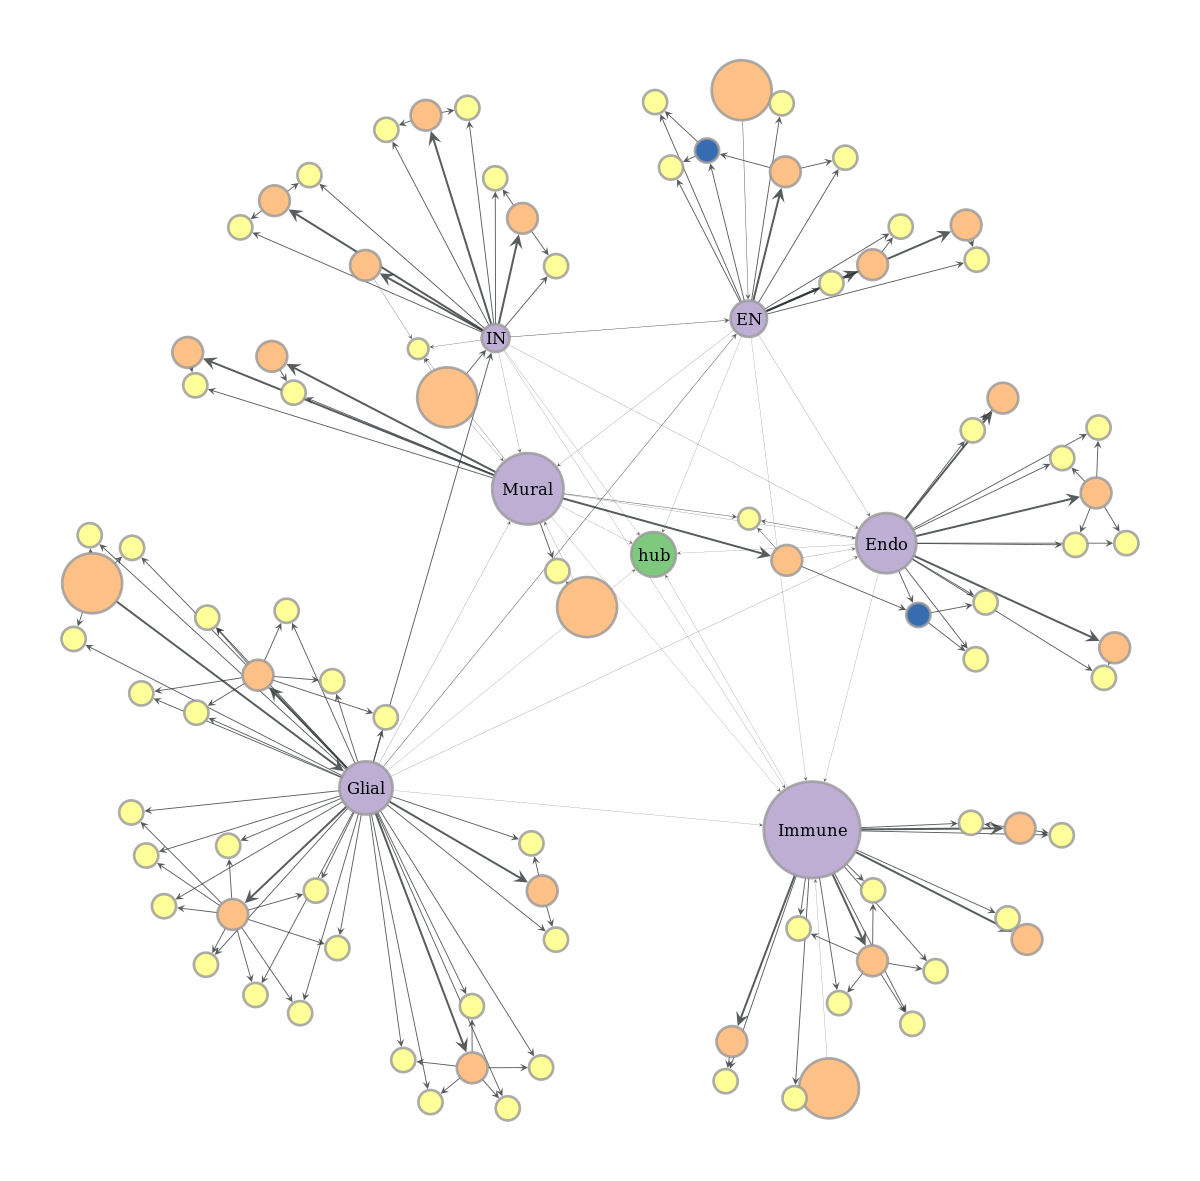

In [6]:
# Load metadata
meta = pd.read_csv('./data/PsychAD_freeze2_personalized_grpahs/syn26527784_latest.csv')

# Compute and plot graph statistics
# x = 'BRAAK_AD';  x_sub = 'nps_WtLossCurValue'
# graph_summary = compute_statistics(meta, x, x_sub)
# plot_regulon_statistics(graph_summary, x=x, x_sub=x_sub, prefix='Attention-Filtered')

# Visualize select graph
g = compute_graph(load_graph_by_id('M48992'))
visualize_graph(g)